# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [50]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

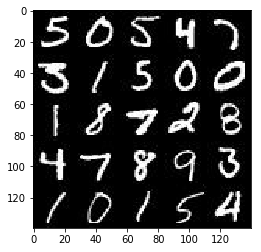

In [51]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

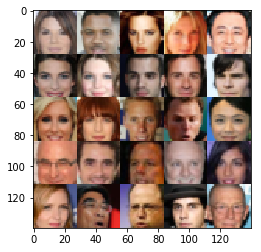

In [52]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [53]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [54]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(dtype=tf.float32, \
                                shape=[None, image_width, image_height, image_channels], \
                                name="input_real")
    
    input_z = tf.placeholder(dtype=tf.float32, \
                             shape=[None, z_dim], \
                             name='input_z')
    
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [55]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        z1 = tf.layers.conv2d(images, filters=128, kernel_size=5, strides=2, padding='same', \
                              activation=None, use_bias=True)
        z1 = tf.maximum(alpha*z1, z1)
        
        z2 = tf.layers.conv2d(z1, filters=256, kernel_size=5, strides=2, padding='same', \
                              activation=None, use_bias=False)
        z2 = tf.layers.batch_normalization(z2, training=True)
        z2 = tf.maximum(alpha*z2, z2)
        
        z3 = tf.layers.conv2d(z2, filters=512, kernel_size=5, strides=2, padding='same', \
                              activation=None, use_bias=False)
        z3 = tf.layers.batch_normalization(z2, training=True)
        z3 = tf.maximum(alpha*z3, z3)
        z3_shape = z3.get_shape().as_list()

        z4 = tf.reshape(z3, shape=[-1, z3_shape[1]*z3_shape[2]*z3_shape[3]]) # from tensor z3.get_shape() 
        logits = tf.layers.dense(z4, 1, activation=None, use_bias=True) # final layer use bias for no batch normalization implemented
        output = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [56]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        x1 = tf.layers.dense(z, units=7*7*256, activation=None)
        x1 = tf.reshape(x1, shape=[-1, 7, 7, 256])
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # Output shape 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, filters=128, kernel_size=5, strides=2, padding='same', \
                                        activation=None, use_bias=False)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # Output shape 14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, filters=64, kernel_size=5, strides=2, padding='same', \
                                            activation=None, use_bias=False)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # Output shape 28x28x64
        
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=1, padding='same', \
                                            activation=None, use_bias=True) # for fitting to out_channel_dim
        # Output shape 28x28xout_channel_dim
        
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [57]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_images = generator(input_z, out_channel_dim)
    
    output_real , logits_real = discriminator(input_real)
    output_fake, logits_fake = discriminator(g_images, reuse=True)
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), \
                                                                         logits=logits_real))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake), \
                                                                         logits=logits_fake))
    d_loss = d_real_loss + d_fake_loss
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake), \
                                                                    logits=logits_fake))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [58]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, \
                                                                                                var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, \
                                                                                                var_list=g_vars)
    
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [59]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [60]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    input_real_holder, input_z_holder, learning_rate_holder = model_inputs(data_shape[1], data_shape[2], \
                                                                           data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real_holder, input_z_holder, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_holder, beta1)
    
    saver = tf.train.Saver() # for saving all the variables above
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                
                # get batches for fake images
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                # scale batch_images pixel value between -1 and 1
                batch_images *= 2
                
                # TODO: Train Model 
                _ =sess.run(d_train_opt, feed_dict={input_real_holder: batch_images, \
                                                    input_z_holder: batch_z, \
                                                    learning_rate_holder: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z_holder: batch_z, \
                                                     input_real_holder: batch_images, \
                                                     learning_rate_holder: learning_rate})
                
                if step % 10 == 0:
                    train_d_loss = d_loss.eval({input_real_holder: batch_images, \
                                                input_z_holder: batch_z})
                    train_g_loss = g_loss.eval({input_z_holder: batch_z})
                    
                    print('Epoch: {}/{}...'.format(epoch_i+1, epoch_count),
                          'Discriminator Training Loss: {:.4f}'.format(train_d_loss),
                          'Generator Training Loss: {:.4f}'.format(train_g_loss))
                    
                if step % 100 == 0:    
                    _ = show_generator_output(sess, n_images=16, \
                                              input_z=input_z_holder, \
                                              out_channel_dim=data_shape[3], \
                                              image_mode=data_image_mode)
        
        # print out the generated sample from final model
        _ = show_generator_output(sess, n_images=16, \
                                  input_z=input_z_holder, \
                                  out_channel_dim=data_shape[3], \
                                  image_mode=data_image_mode)
        
        saver.save(sess, './generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1/2... Discriminator Training Loss: 0.6127 Generator Training Loss: 1.0418
Epoch: 1/2... Discriminator Training Loss: 1.3307 Generator Training Loss: 1.0124
Epoch: 1/2... Discriminator Training Loss: 2.0706 Generator Training Loss: 0.1848
Epoch: 1/2... Discriminator Training Loss: 1.8369 Generator Training Loss: 0.2205
Epoch: 1/2... Discriminator Training Loss: 1.5197 Generator Training Loss: 0.3418
Epoch: 1/2... Discriminator Training Loss: 1.5752 Generator Training Loss: 0.3158
Epoch: 1/2... Discriminator Training Loss: 1.5425 Generator Training Loss: 0.3277
Epoch: 1/2... Discriminator Training Loss: 1.3567 Generator Training Loss: 0.4229
Epoch: 1/2... Discriminator Training Loss: 1.3573 Generator Training Loss: 0.4134
Epoch: 1/2... Discriminator Training Loss: 1.3067 Generator Training Loss: 0.4288


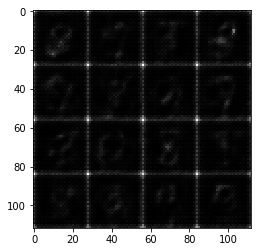

Epoch: 1/2... Discriminator Training Loss: 1.2356 Generator Training Loss: 0.4612
Epoch: 1/2... Discriminator Training Loss: 1.4316 Generator Training Loss: 0.3431
Epoch: 1/2... Discriminator Training Loss: 1.4482 Generator Training Loss: 0.3381
Epoch: 1/2... Discriminator Training Loss: 0.8090 Generator Training Loss: 0.8790
Epoch: 1/2... Discriminator Training Loss: 1.1400 Generator Training Loss: 0.5292
Epoch: 1/2... Discriminator Training Loss: 1.2761 Generator Training Loss: 0.4408
Epoch: 1/2... Discriminator Training Loss: 1.1922 Generator Training Loss: 2.6505
Epoch: 1/2... Discriminator Training Loss: 0.7407 Generator Training Loss: 1.2806
Epoch: 1/2... Discriminator Training Loss: 0.8840 Generator Training Loss: 1.2102
Epoch: 1/2... Discriminator Training Loss: 1.2192 Generator Training Loss: 2.0480


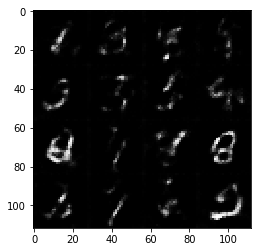

Epoch: 1/2... Discriminator Training Loss: 0.7147 Generator Training Loss: 2.1468
Epoch: 1/2... Discriminator Training Loss: 0.9391 Generator Training Loss: 1.3358
Epoch: 1/2... Discriminator Training Loss: 0.9579 Generator Training Loss: 1.4612
Epoch: 1/2... Discriminator Training Loss: 1.3047 Generator Training Loss: 1.7295
Epoch: 1/2... Discriminator Training Loss: 1.3840 Generator Training Loss: 1.6477
Epoch: 1/2... Discriminator Training Loss: 1.2999 Generator Training Loss: 1.7833
Epoch: 1/2... Discriminator Training Loss: 1.1366 Generator Training Loss: 1.2079
Epoch: 1/2... Discriminator Training Loss: 1.3274 Generator Training Loss: 1.5268
Epoch: 1/2... Discriminator Training Loss: 1.1464 Generator Training Loss: 1.4927
Epoch: 1/2... Discriminator Training Loss: 1.2904 Generator Training Loss: 1.7019


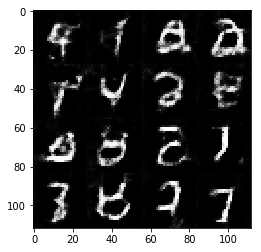

Epoch: 1/2... Discriminator Training Loss: 1.4449 Generator Training Loss: 1.9482
Epoch: 1/2... Discriminator Training Loss: 1.1379 Generator Training Loss: 1.2835
Epoch: 1/2... Discriminator Training Loss: 1.1107 Generator Training Loss: 1.0455
Epoch: 1/2... Discriminator Training Loss: 1.3656 Generator Training Loss: 1.6560
Epoch: 1/2... Discriminator Training Loss: 1.2587 Generator Training Loss: 1.3879
Epoch: 1/2... Discriminator Training Loss: 1.1682 Generator Training Loss: 1.4553
Epoch: 1/2... Discriminator Training Loss: 1.1815 Generator Training Loss: 1.0966
Epoch: 1/2... Discriminator Training Loss: 1.3015 Generator Training Loss: 1.4723
Epoch: 1/2... Discriminator Training Loss: 1.2356 Generator Training Loss: 1.5010
Epoch: 1/2... Discriminator Training Loss: 1.3947 Generator Training Loss: 0.3954


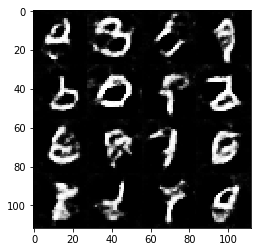

Epoch: 1/2... Discriminator Training Loss: 1.2980 Generator Training Loss: 0.4606
Epoch: 1/2... Discriminator Training Loss: 1.4531 Generator Training Loss: 0.3749
Epoch: 1/2... Discriminator Training Loss: 1.1404 Generator Training Loss: 0.6516
Epoch: 1/2... Discriminator Training Loss: 1.5151 Generator Training Loss: 0.3506
Epoch: 1/2... Discriminator Training Loss: 1.3968 Generator Training Loss: 0.4017
Epoch: 1/2... Discriminator Training Loss: 1.1076 Generator Training Loss: 0.6682
Epoch: 2/2... Discriminator Training Loss: 1.3404 Generator Training Loss: 0.4714
Epoch: 2/2... Discriminator Training Loss: 1.1150 Generator Training Loss: 0.6654
Epoch: 2/2... Discriminator Training Loss: 1.1445 Generator Training Loss: 0.5909
Epoch: 2/2... Discriminator Training Loss: 1.2846 Generator Training Loss: 0.4899


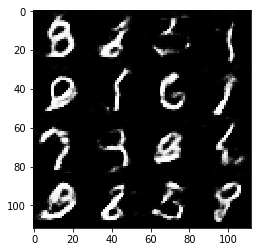

Epoch: 2/2... Discriminator Training Loss: 1.1443 Generator Training Loss: 0.6772
Epoch: 2/2... Discriminator Training Loss: 1.2227 Generator Training Loss: 1.5710
Epoch: 2/2... Discriminator Training Loss: 1.3759 Generator Training Loss: 1.7441
Epoch: 2/2... Discriminator Training Loss: 1.0189 Generator Training Loss: 1.1103
Epoch: 2/2... Discriminator Training Loss: 1.1508 Generator Training Loss: 1.5206
Epoch: 2/2... Discriminator Training Loss: 1.0815 Generator Training Loss: 1.4775
Epoch: 2/2... Discriminator Training Loss: 1.2719 Generator Training Loss: 1.8482
Epoch: 2/2... Discriminator Training Loss: 1.1951 Generator Training Loss: 0.7994
Epoch: 2/2... Discriminator Training Loss: 1.0447 Generator Training Loss: 0.8953
Epoch: 2/2... Discriminator Training Loss: 0.9732 Generator Training Loss: 1.2071


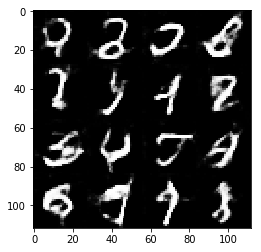

Epoch: 2/2... Discriminator Training Loss: 1.1652 Generator Training Loss: 1.5051
Epoch: 2/2... Discriminator Training Loss: 1.0825 Generator Training Loss: 1.3907
Epoch: 2/2... Discriminator Training Loss: 1.1707 Generator Training Loss: 1.4846
Epoch: 2/2... Discriminator Training Loss: 1.1183 Generator Training Loss: 1.2713
Epoch: 2/2... Discriminator Training Loss: 1.4477 Generator Training Loss: 1.7138
Epoch: 2/2... Discriminator Training Loss: 1.2389 Generator Training Loss: 1.4540
Epoch: 2/2... Discriminator Training Loss: 1.1625 Generator Training Loss: 1.3048
Epoch: 2/2... Discriminator Training Loss: 1.1558 Generator Training Loss: 0.5393
Epoch: 2/2... Discriminator Training Loss: 1.8696 Generator Training Loss: 0.2177
Epoch: 2/2... Discriminator Training Loss: 1.0259 Generator Training Loss: 0.6898


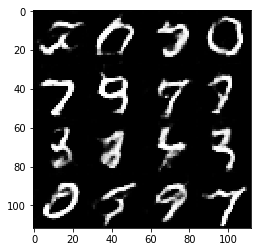

Epoch: 2/2... Discriminator Training Loss: 1.0821 Generator Training Loss: 0.7205
Epoch: 2/2... Discriminator Training Loss: 1.3214 Generator Training Loss: 0.5253
Epoch: 2/2... Discriminator Training Loss: 1.3599 Generator Training Loss: 0.4018
Epoch: 2/2... Discriminator Training Loss: 1.1885 Generator Training Loss: 0.5257
Epoch: 2/2... Discriminator Training Loss: 1.2993 Generator Training Loss: 0.4548
Epoch: 2/2... Discriminator Training Loss: 1.2507 Generator Training Loss: 0.4904
Epoch: 2/2... Discriminator Training Loss: 1.1550 Generator Training Loss: 0.5698
Epoch: 2/2... Discriminator Training Loss: 1.3999 Generator Training Loss: 0.3927
Epoch: 2/2... Discriminator Training Loss: 0.9699 Generator Training Loss: 1.1257
Epoch: 2/2... Discriminator Training Loss: 1.1383 Generator Training Loss: 1.4005


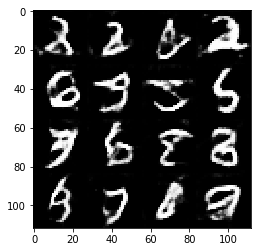

Epoch: 2/2... Discriminator Training Loss: 1.1670 Generator Training Loss: 1.7524
Epoch: 2/2... Discriminator Training Loss: 1.0048 Generator Training Loss: 1.3826
Epoch: 2/2... Discriminator Training Loss: 1.1746 Generator Training Loss: 1.5880
Epoch: 2/2... Discriminator Training Loss: 1.2025 Generator Training Loss: 1.6917
Epoch: 2/2... Discriminator Training Loss: 1.0605 Generator Training Loss: 1.7736
Epoch: 2/2... Discriminator Training Loss: 0.9988 Generator Training Loss: 0.7952
Epoch: 2/2... Discriminator Training Loss: 1.3121 Generator Training Loss: 0.5218
Epoch: 2/2... Discriminator Training Loss: 1.1336 Generator Training Loss: 0.5805
Epoch: 2/2... Discriminator Training Loss: 1.2082 Generator Training Loss: 0.5200
Epoch: 2/2... Discriminator Training Loss: 1.5019 Generator Training Loss: 0.3302


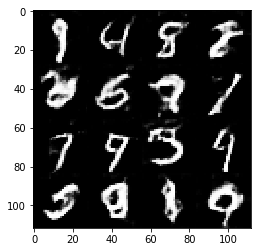

Epoch: 2/2... Discriminator Training Loss: 1.0279 Generator Training Loss: 0.8397
Epoch: 2/2... Discriminator Training Loss: 1.5322 Generator Training Loss: 0.3101
Epoch: 2/2... Discriminator Training Loss: 1.3088 Generator Training Loss: 0.4297


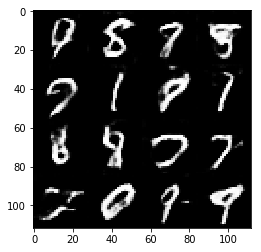

In [61]:
batch_size = 128
z_dim = 100
learning_rate = 0.0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1/1... Discriminator Training Loss: 0.6870 Generator Training Loss: 0.9934
Epoch: 1/1... Discriminator Training Loss: 0.5918 Generator Training Loss: 1.5294
Epoch: 1/1... Discriminator Training Loss: 0.4732 Generator Training Loss: 1.3846
Epoch: 1/1... Discriminator Training Loss: 0.1433 Generator Training Loss: 3.1253
Epoch: 1/1... Discriminator Training Loss: 2.1325 Generator Training Loss: 0.2253
Epoch: 1/1... Discriminator Training Loss: 0.8561 Generator Training Loss: 0.8850
Epoch: 1/1... Discriminator Training Loss: 0.4225 Generator Training Loss: 1.7970
Epoch: 1/1... Discriminator Training Loss: 0.6947 Generator Training Loss: 1.5242
Epoch: 1/1... Discriminator Training Loss: 1.4672 Generator Training Loss: 4.7321
Epoch: 1/1... Discriminator Training Loss: 0.9095 Generator Training Loss: 3.6456


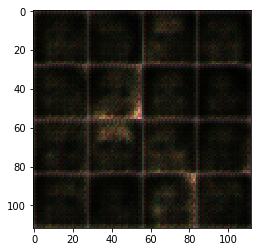

Epoch: 1/1... Discriminator Training Loss: 0.5343 Generator Training Loss: 1.6829
Epoch: 1/1... Discriminator Training Loss: 0.3288 Generator Training Loss: 2.8571
Epoch: 1/1... Discriminator Training Loss: 0.3033 Generator Training Loss: 2.1377
Epoch: 1/1... Discriminator Training Loss: 0.5097 Generator Training Loss: 1.8067
Epoch: 1/1... Discriminator Training Loss: 0.8522 Generator Training Loss: 0.9629
Epoch: 1/1... Discriminator Training Loss: 0.2366 Generator Training Loss: 2.6721
Epoch: 1/1... Discriminator Training Loss: 0.2202 Generator Training Loss: 2.6512
Epoch: 1/1... Discriminator Training Loss: 0.2907 Generator Training Loss: 2.5534
Epoch: 1/1... Discriminator Training Loss: 0.8646 Generator Training Loss: 4.9747
Epoch: 1/1... Discriminator Training Loss: 0.8137 Generator Training Loss: 0.9459


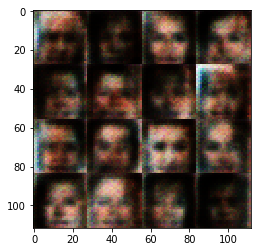

Epoch: 1/1... Discriminator Training Loss: 0.6644 Generator Training Loss: 3.4172
Epoch: 1/1... Discriminator Training Loss: 1.2379 Generator Training Loss: 0.7760
Epoch: 1/1... Discriminator Training Loss: 0.6532 Generator Training Loss: 1.1233
Epoch: 1/1... Discriminator Training Loss: 1.1176 Generator Training Loss: 0.6122
Epoch: 1/1... Discriminator Training Loss: 0.6259 Generator Training Loss: 1.6005
Epoch: 1/1... Discriminator Training Loss: 1.9747 Generator Training Loss: 6.9566
Epoch: 1/1... Discriminator Training Loss: 1.0957 Generator Training Loss: 0.5846
Epoch: 1/1... Discriminator Training Loss: 0.5906 Generator Training Loss: 4.8499
Epoch: 1/1... Discriminator Training Loss: 0.1347 Generator Training Loss: 3.2411
Epoch: 1/1... Discriminator Training Loss: 0.4524 Generator Training Loss: 4.0323


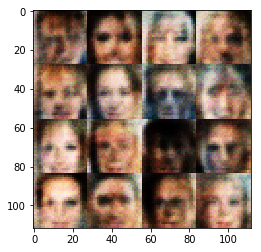

Epoch: 1/1... Discriminator Training Loss: 0.6639 Generator Training Loss: 1.0193
Epoch: 1/1... Discriminator Training Loss: 0.4761 Generator Training Loss: 1.4253
Epoch: 1/1... Discriminator Training Loss: 0.9666 Generator Training Loss: 0.6782
Epoch: 1/1... Discriminator Training Loss: 0.4619 Generator Training Loss: 1.3145
Epoch: 1/1... Discriminator Training Loss: 0.0458 Generator Training Loss: 5.9823
Epoch: 1/1... Discriminator Training Loss: 0.1076 Generator Training Loss: 3.3169
Epoch: 1/1... Discriminator Training Loss: 0.0609 Generator Training Loss: 6.7454
Epoch: 1/1... Discriminator Training Loss: 0.0798 Generator Training Loss: 5.3584
Epoch: 1/1... Discriminator Training Loss: 1.5915 Generator Training Loss: 0.3783
Epoch: 1/1... Discriminator Training Loss: 0.9871 Generator Training Loss: 7.1629


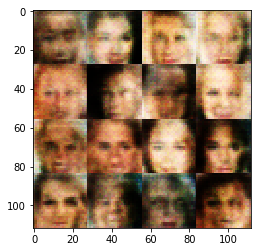

Epoch: 1/1... Discriminator Training Loss: 0.2030 Generator Training Loss: 5.3887
Epoch: 1/1... Discriminator Training Loss: 0.3453 Generator Training Loss: 1.8718
Epoch: 1/1... Discriminator Training Loss: 1.0397 Generator Training Loss: 5.1835
Epoch: 1/1... Discriminator Training Loss: 0.0823 Generator Training Loss: 4.5862
Epoch: 1/1... Discriminator Training Loss: 0.0831 Generator Training Loss: 4.2600
Epoch: 1/1... Discriminator Training Loss: 0.2842 Generator Training Loss: 2.3496
Epoch: 1/1... Discriminator Training Loss: 0.3864 Generator Training Loss: 1.7150
Epoch: 1/1... Discriminator Training Loss: 0.0354 Generator Training Loss: 6.1806
Epoch: 1/1... Discriminator Training Loss: 1.6438 Generator Training Loss: 0.3109
Epoch: 1/1... Discriminator Training Loss: 0.0827 Generator Training Loss: 7.0340


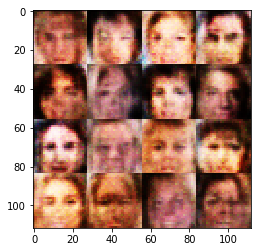

Epoch: 1/1... Discriminator Training Loss: 0.7563 Generator Training Loss: 0.8541
Epoch: 1/1... Discriminator Training Loss: 0.2238 Generator Training Loss: 5.5972
Epoch: 1/1... Discriminator Training Loss: 0.4825 Generator Training Loss: 1.6034
Epoch: 1/1... Discriminator Training Loss: 0.0911 Generator Training Loss: 5.5972
Epoch: 1/1... Discriminator Training Loss: 0.0656 Generator Training Loss: 6.6140
Epoch: 1/1... Discriminator Training Loss: 2.7183 Generator Training Loss: 0.1124
Epoch: 1/1... Discriminator Training Loss: 1.2863 Generator Training Loss: 0.5127
Epoch: 1/1... Discriminator Training Loss: 0.8833 Generator Training Loss: 5.8931
Epoch: 1/1... Discriminator Training Loss: 0.7161 Generator Training Loss: 6.3790
Epoch: 1/1... Discriminator Training Loss: 0.5947 Generator Training Loss: 1.3339


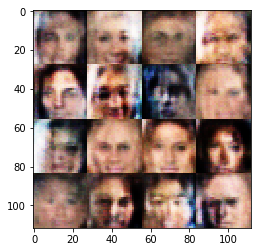

Epoch: 1/1... Discriminator Training Loss: 0.6209 Generator Training Loss: 4.1341
Epoch: 1/1... Discriminator Training Loss: 0.1365 Generator Training Loss: 6.1723
Epoch: 1/1... Discriminator Training Loss: 0.3980 Generator Training Loss: 2.3491
Epoch: 1/1... Discriminator Training Loss: 0.2768 Generator Training Loss: 5.2496
Epoch: 1/1... Discriminator Training Loss: 0.1211 Generator Training Loss: 3.4347
Epoch: 1/1... Discriminator Training Loss: 0.1073 Generator Training Loss: 4.3699
Epoch: 1/1... Discriminator Training Loss: 1.7237 Generator Training Loss: 8.5977
Epoch: 1/1... Discriminator Training Loss: 0.0483 Generator Training Loss: 4.9752
Epoch: 1/1... Discriminator Training Loss: 0.2011 Generator Training Loss: 2.9668
Epoch: 1/1... Discriminator Training Loss: 0.1506 Generator Training Loss: 5.2368


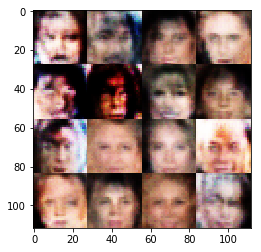

Epoch: 1/1... Discriminator Training Loss: 1.2019 Generator Training Loss: 4.4331
Epoch: 1/1... Discriminator Training Loss: 0.1837 Generator Training Loss: 2.9169
Epoch: 1/1... Discriminator Training Loss: 0.2162 Generator Training Loss: 2.9847
Epoch: 1/1... Discriminator Training Loss: 0.3812 Generator Training Loss: 1.7129
Epoch: 1/1... Discriminator Training Loss: 0.2546 Generator Training Loss: 4.2501
Epoch: 1/1... Discriminator Training Loss: 0.4301 Generator Training Loss: 1.6280
Epoch: 1/1... Discriminator Training Loss: 0.3922 Generator Training Loss: 1.6140
Epoch: 1/1... Discriminator Training Loss: 0.5914 Generator Training Loss: 7.3578
Epoch: 1/1... Discriminator Training Loss: 0.6203 Generator Training Loss: 1.0822
Epoch: 1/1... Discriminator Training Loss: 0.9136 Generator Training Loss: 1.1613


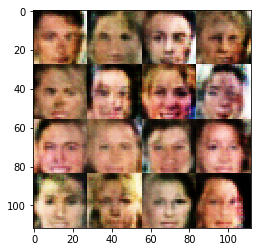

Epoch: 1/1... Discriminator Training Loss: 0.3512 Generator Training Loss: 3.8791
Epoch: 1/1... Discriminator Training Loss: 0.1796 Generator Training Loss: 2.7317
Epoch: 1/1... Discriminator Training Loss: 0.3523 Generator Training Loss: 5.6090
Epoch: 1/1... Discriminator Training Loss: 0.1195 Generator Training Loss: 4.4238
Epoch: 1/1... Discriminator Training Loss: 1.1897 Generator Training Loss: 6.8745
Epoch: 1/1... Discriminator Training Loss: 0.2712 Generator Training Loss: 2.1905
Epoch: 1/1... Discriminator Training Loss: 0.1496 Generator Training Loss: 3.5146
Epoch: 1/1... Discriminator Training Loss: 0.4995 Generator Training Loss: 1.5050
Epoch: 1/1... Discriminator Training Loss: 0.4686 Generator Training Loss: 5.6083
Epoch: 1/1... Discriminator Training Loss: 0.3388 Generator Training Loss: 1.7505


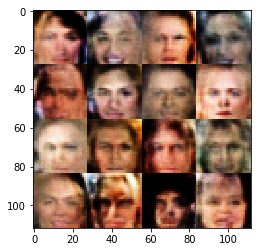

Epoch: 1/1... Discriminator Training Loss: 0.5879 Generator Training Loss: 1.1252
Epoch: 1/1... Discriminator Training Loss: 1.8664 Generator Training Loss: 0.2478
Epoch: 1/1... Discriminator Training Loss: 1.0640 Generator Training Loss: 0.7167
Epoch: 1/1... Discriminator Training Loss: 0.3323 Generator Training Loss: 2.7450
Epoch: 1/1... Discriminator Training Loss: 0.1552 Generator Training Loss: 4.6979
Epoch: 1/1... Discriminator Training Loss: 0.2862 Generator Training Loss: 3.3565
Epoch: 1/1... Discriminator Training Loss: 0.4673 Generator Training Loss: 1.3262
Epoch: 1/1... Discriminator Training Loss: 0.1730 Generator Training Loss: 3.4460
Epoch: 1/1... Discriminator Training Loss: 0.3002 Generator Training Loss: 2.0157
Epoch: 1/1... Discriminator Training Loss: 0.1988 Generator Training Loss: 4.1930


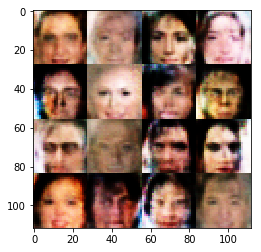

Epoch: 1/1... Discriminator Training Loss: 0.3903 Generator Training Loss: 1.4717
Epoch: 1/1... Discriminator Training Loss: 0.2461 Generator Training Loss: 6.2193
Epoch: 1/1... Discriminator Training Loss: 0.1121 Generator Training Loss: 5.2524
Epoch: 1/1... Discriminator Training Loss: 0.5636 Generator Training Loss: 2.9218
Epoch: 1/1... Discriminator Training Loss: 0.2185 Generator Training Loss: 2.6314
Epoch: 1/1... Discriminator Training Loss: 1.1873 Generator Training Loss: 5.7182
Epoch: 1/1... Discriminator Training Loss: 0.4279 Generator Training Loss: 1.9276
Epoch: 1/1... Discriminator Training Loss: 0.2533 Generator Training Loss: 3.5602
Epoch: 1/1... Discriminator Training Loss: 0.1499 Generator Training Loss: 3.6224
Epoch: 1/1... Discriminator Training Loss: 0.5064 Generator Training Loss: 1.2770


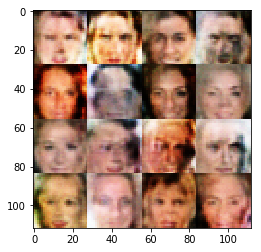

Epoch: 1/1... Discriminator Training Loss: 0.5674 Generator Training Loss: 4.5128
Epoch: 1/1... Discriminator Training Loss: 0.1506 Generator Training Loss: 3.1797
Epoch: 1/1... Discriminator Training Loss: 0.1849 Generator Training Loss: 2.7910
Epoch: 1/1... Discriminator Training Loss: 0.4814 Generator Training Loss: 1.2632
Epoch: 1/1... Discriminator Training Loss: 0.4327 Generator Training Loss: 1.4561
Epoch: 1/1... Discriminator Training Loss: 1.8786 Generator Training Loss: 0.2154
Epoch: 1/1... Discriminator Training Loss: 0.2069 Generator Training Loss: 2.9609
Epoch: 1/1... Discriminator Training Loss: 0.1686 Generator Training Loss: 3.6468
Epoch: 1/1... Discriminator Training Loss: 0.1575 Generator Training Loss: 2.8266
Epoch: 1/1... Discriminator Training Loss: 0.5482 Generator Training Loss: 4.4517


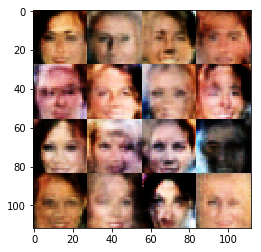

Epoch: 1/1... Discriminator Training Loss: 1.6855 Generator Training Loss: 0.3759
Epoch: 1/1... Discriminator Training Loss: 0.9268 Generator Training Loss: 0.7508
Epoch: 1/1... Discriminator Training Loss: 0.3858 Generator Training Loss: 1.8825
Epoch: 1/1... Discriminator Training Loss: 0.3802 Generator Training Loss: 3.7815
Epoch: 1/1... Discriminator Training Loss: 0.1608 Generator Training Loss: 3.7979
Epoch: 1/1... Discriminator Training Loss: 0.2093 Generator Training Loss: 3.8808
Epoch: 1/1... Discriminator Training Loss: 0.2753 Generator Training Loss: 2.2700
Epoch: 1/1... Discriminator Training Loss: 0.5387 Generator Training Loss: 1.2811
Epoch: 1/1... Discriminator Training Loss: 2.2553 Generator Training Loss: 0.2016
Epoch: 1/1... Discriminator Training Loss: 0.6659 Generator Training Loss: 1.7741


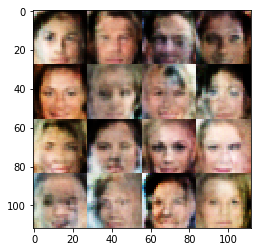

Epoch: 1/1... Discriminator Training Loss: 0.2747 Generator Training Loss: 2.1635
Epoch: 1/1... Discriminator Training Loss: 0.2717 Generator Training Loss: 1.9739
Epoch: 1/1... Discriminator Training Loss: 0.1598 Generator Training Loss: 3.0401
Epoch: 1/1... Discriminator Training Loss: 1.2330 Generator Training Loss: 0.5151
Epoch: 1/1... Discriminator Training Loss: 0.4297 Generator Training Loss: 3.6109
Epoch: 1/1... Discriminator Training Loss: 0.2589 Generator Training Loss: 2.0684
Epoch: 1/1... Discriminator Training Loss: 0.2075 Generator Training Loss: 2.7799
Epoch: 1/1... Discriminator Training Loss: 0.2976 Generator Training Loss: 2.5975
Epoch: 1/1... Discriminator Training Loss: 1.5107 Generator Training Loss: 0.3799
Epoch: 1/1... Discriminator Training Loss: 0.6429 Generator Training Loss: 0.9939


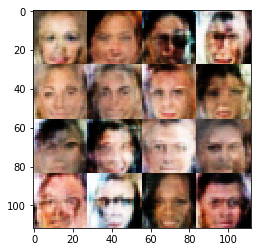

Epoch: 1/1... Discriminator Training Loss: 0.3807 Generator Training Loss: 1.7329
Epoch: 1/1... Discriminator Training Loss: 0.7192 Generator Training Loss: 0.9259
Epoch: 1/1... Discriminator Training Loss: 0.3301 Generator Training Loss: 3.0822
Epoch: 1/1... Discriminator Training Loss: 0.2431 Generator Training Loss: 2.6732
Epoch: 1/1... Discriminator Training Loss: 0.4688 Generator Training Loss: 1.3734
Epoch: 1/1... Discriminator Training Loss: 0.3617 Generator Training Loss: 1.6203
Epoch: 1/1... Discriminator Training Loss: 0.1678 Generator Training Loss: 2.6939
Epoch: 1/1... Discriminator Training Loss: 0.3533 Generator Training Loss: 4.2919
Epoch: 1/1... Discriminator Training Loss: 0.8732 Generator Training Loss: 1.2511
Epoch: 1/1... Discriminator Training Loss: 0.7474 Generator Training Loss: 2.4423


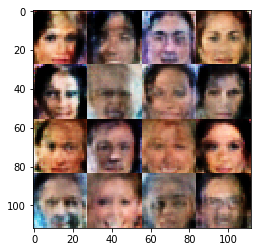

Epoch: 1/1... Discriminator Training Loss: 0.4040 Generator Training Loss: 2.3502
Epoch: 1/1... Discriminator Training Loss: 0.2848 Generator Training Loss: 2.1027
Epoch: 1/1... Discriminator Training Loss: 0.7145 Generator Training Loss: 2.7476
Epoch: 1/1... Discriminator Training Loss: 0.4195 Generator Training Loss: 2.0512
Epoch: 1/1... Discriminator Training Loss: 1.1111 Generator Training Loss: 5.9821
Epoch: 1/1... Discriminator Training Loss: 0.1822 Generator Training Loss: 3.5381
Epoch: 1/1... Discriminator Training Loss: 0.5195 Generator Training Loss: 1.4209
Epoch: 1/1... Discriminator Training Loss: 0.7757 Generator Training Loss: 0.9345
Epoch: 1/1... Discriminator Training Loss: 0.2940 Generator Training Loss: 3.5572
Epoch: 1/1... Discriminator Training Loss: 0.2090 Generator Training Loss: 2.5840


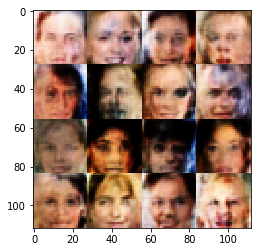

Epoch: 1/1... Discriminator Training Loss: 0.8944 Generator Training Loss: 0.7521
Epoch: 1/1... Discriminator Training Loss: 0.1173 Generator Training Loss: 4.0153
Epoch: 1/1... Discriminator Training Loss: 0.4192 Generator Training Loss: 4.9611
Epoch: 1/1... Discriminator Training Loss: 0.2477 Generator Training Loss: 2.6190
Epoch: 1/1... Discriminator Training Loss: 0.1115 Generator Training Loss: 3.4679
Epoch: 1/1... Discriminator Training Loss: 0.5913 Generator Training Loss: 4.7729
Epoch: 1/1... Discriminator Training Loss: 1.0779 Generator Training Loss: 3.0654
Epoch: 1/1... Discriminator Training Loss: 0.3347 Generator Training Loss: 2.0156
Epoch: 1/1... Discriminator Training Loss: 0.3307 Generator Training Loss: 1.9690
Epoch: 1/1... Discriminator Training Loss: 0.5848 Generator Training Loss: 3.4902


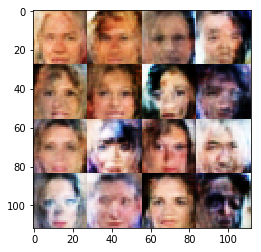

Epoch: 1/1... Discriminator Training Loss: 1.0122 Generator Training Loss: 0.7290
Epoch: 1/1... Discriminator Training Loss: 0.2430 Generator Training Loss: 2.9287
Epoch: 1/1... Discriminator Training Loss: 0.2945 Generator Training Loss: 4.0035
Epoch: 1/1... Discriminator Training Loss: 0.2198 Generator Training Loss: 2.6529
Epoch: 1/1... Discriminator Training Loss: 0.5692 Generator Training Loss: 1.2281
Epoch: 1/1... Discriminator Training Loss: 0.6612 Generator Training Loss: 5.7699
Epoch: 1/1... Discriminator Training Loss: 1.3579 Generator Training Loss: 0.4349
Epoch: 1/1... Discriminator Training Loss: 0.3051 Generator Training Loss: 2.0901
Epoch: 1/1... Discriminator Training Loss: 0.4515 Generator Training Loss: 1.5046
Epoch: 1/1... Discriminator Training Loss: 1.0215 Generator Training Loss: 0.5673


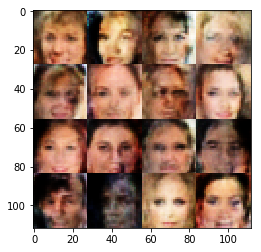

Epoch: 1/1... Discriminator Training Loss: 0.1867 Generator Training Loss: 3.6015
Epoch: 1/1... Discriminator Training Loss: 0.8979 Generator Training Loss: 0.7765
Epoch: 1/1... Discriminator Training Loss: 0.1210 Generator Training Loss: 3.4440
Epoch: 1/1... Discriminator Training Loss: 0.3957 Generator Training Loss: 1.5524
Epoch: 1/1... Discriminator Training Loss: 1.9565 Generator Training Loss: 4.0602
Epoch: 1/1... Discriminator Training Loss: 0.6222 Generator Training Loss: 1.1596
Epoch: 1/1... Discriminator Training Loss: 0.6411 Generator Training Loss: 1.0592
Epoch: 1/1... Discriminator Training Loss: 0.6076 Generator Training Loss: 1.1257
Epoch: 1/1... Discriminator Training Loss: 0.1653 Generator Training Loss: 3.3635
Epoch: 1/1... Discriminator Training Loss: 1.0051 Generator Training Loss: 3.4358


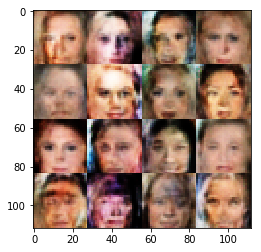

Epoch: 1/1... Discriminator Training Loss: 0.7910 Generator Training Loss: 0.8544
Epoch: 1/1... Discriminator Training Loss: 0.5277 Generator Training Loss: 1.3509
Epoch: 1/1... Discriminator Training Loss: 0.7834 Generator Training Loss: 0.8657
Epoch: 1/1... Discriminator Training Loss: 0.2102 Generator Training Loss: 3.4634
Epoch: 1/1... Discriminator Training Loss: 1.5451 Generator Training Loss: 0.3255
Epoch: 1/1... Discriminator Training Loss: 0.7225 Generator Training Loss: 1.0280
Epoch: 1/1... Discriminator Training Loss: 0.1727 Generator Training Loss: 2.9693
Epoch: 1/1... Discriminator Training Loss: 0.1452 Generator Training Loss: 3.4318
Epoch: 1/1... Discriminator Training Loss: 0.6738 Generator Training Loss: 1.0109
Epoch: 1/1... Discriminator Training Loss: 0.6330 Generator Training Loss: 1.1621


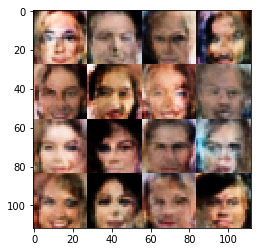

Epoch: 1/1... Discriminator Training Loss: 0.3564 Generator Training Loss: 1.4749
Epoch: 1/1... Discriminator Training Loss: 1.2972 Generator Training Loss: 4.4469
Epoch: 1/1... Discriminator Training Loss: 0.5601 Generator Training Loss: 4.9310
Epoch: 1/1... Discriminator Training Loss: 0.3649 Generator Training Loss: 1.8068
Epoch: 1/1... Discriminator Training Loss: 0.6087 Generator Training Loss: 1.1661
Epoch: 1/1... Discriminator Training Loss: 0.1331 Generator Training Loss: 3.7948
Epoch: 1/1... Discriminator Training Loss: 0.2225 Generator Training Loss: 4.9632
Epoch: 1/1... Discriminator Training Loss: 0.3639 Generator Training Loss: 1.5859
Epoch: 1/1... Discriminator Training Loss: 0.3490 Generator Training Loss: 2.2416
Epoch: 1/1... Discriminator Training Loss: 0.1169 Generator Training Loss: 3.8749


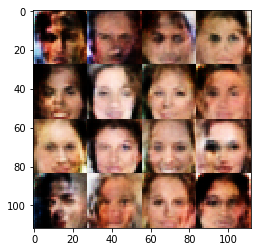

Epoch: 1/1... Discriminator Training Loss: 0.7937 Generator Training Loss: 1.7511
Epoch: 1/1... Discriminator Training Loss: 0.9357 Generator Training Loss: 0.6425
Epoch: 1/1... Discriminator Training Loss: 0.9257 Generator Training Loss: 0.7339
Epoch: 1/1... Discriminator Training Loss: 1.5330 Generator Training Loss: 2.2377
Epoch: 1/1... Discriminator Training Loss: 0.5366 Generator Training Loss: 1.2955
Epoch: 1/1... Discriminator Training Loss: 0.8321 Generator Training Loss: 1.2679
Epoch: 1/1... Discriminator Training Loss: 0.4966 Generator Training Loss: 1.5242
Epoch: 1/1... Discriminator Training Loss: 0.1973 Generator Training Loss: 2.8108
Epoch: 1/1... Discriminator Training Loss: 0.3266 Generator Training Loss: 2.8832
Epoch: 1/1... Discriminator Training Loss: 0.2366 Generator Training Loss: 2.1889


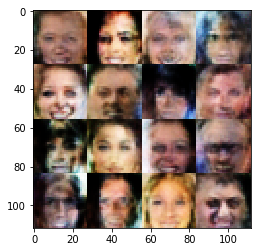

Epoch: 1/1... Discriminator Training Loss: 0.5331 Generator Training Loss: 1.8277
Epoch: 1/1... Discriminator Training Loss: 0.6148 Generator Training Loss: 1.0522
Epoch: 1/1... Discriminator Training Loss: 0.5681 Generator Training Loss: 2.0312
Epoch: 1/1... Discriminator Training Loss: 0.5716 Generator Training Loss: 1.2157
Epoch: 1/1... Discriminator Training Loss: 0.4982 Generator Training Loss: 1.8574
Epoch: 1/1... Discriminator Training Loss: 0.6777 Generator Training Loss: 1.0368
Epoch: 1/1... Discriminator Training Loss: 0.3565 Generator Training Loss: 4.6329
Epoch: 1/1... Discriminator Training Loss: 0.5650 Generator Training Loss: 1.5846
Epoch: 1/1... Discriminator Training Loss: 0.3211 Generator Training Loss: 1.9562
Epoch: 1/1... Discriminator Training Loss: 0.9194 Generator Training Loss: 0.7225


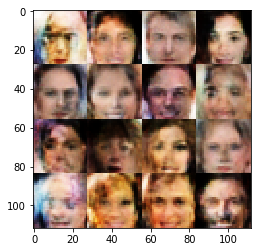

Epoch: 1/1... Discriminator Training Loss: 0.4101 Generator Training Loss: 2.9637
Epoch: 1/1... Discriminator Training Loss: 1.5781 Generator Training Loss: 0.3623
Epoch: 1/1... Discriminator Training Loss: 0.6716 Generator Training Loss: 1.1151
Epoch: 1/1... Discriminator Training Loss: 0.6599 Generator Training Loss: 1.1981
Epoch: 1/1... Discriminator Training Loss: 1.2580 Generator Training Loss: 0.4186
Epoch: 1/1... Discriminator Training Loss: 0.4276 Generator Training Loss: 1.3706
Epoch: 1/1... Discriminator Training Loss: 1.0027 Generator Training Loss: 0.6770
Epoch: 1/1... Discriminator Training Loss: 0.5244 Generator Training Loss: 1.3303
Epoch: 1/1... Discriminator Training Loss: 0.1474 Generator Training Loss: 4.7275
Epoch: 1/1... Discriminator Training Loss: 0.3299 Generator Training Loss: 2.4202


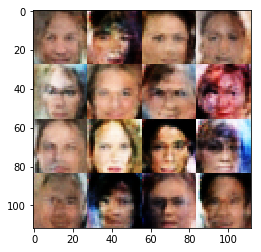

Epoch: 1/1... Discriminator Training Loss: 0.2165 Generator Training Loss: 2.4561
Epoch: 1/1... Discriminator Training Loss: 0.1433 Generator Training Loss: 4.2931
Epoch: 1/1... Discriminator Training Loss: 0.8727 Generator Training Loss: 1.3558
Epoch: 1/1... Discriminator Training Loss: 0.6635 Generator Training Loss: 1.2044
Epoch: 1/1... Discriminator Training Loss: 2.8129 Generator Training Loss: 0.1320
Epoch: 1/1... Discriminator Training Loss: 1.2694 Generator Training Loss: 0.5313
Epoch: 1/1... Discriminator Training Loss: 0.4301 Generator Training Loss: 1.5886
Epoch: 1/1... Discriminator Training Loss: 0.5597 Generator Training Loss: 2.0309
Epoch: 1/1... Discriminator Training Loss: 0.5543 Generator Training Loss: 1.3810
Epoch: 1/1... Discriminator Training Loss: 0.1321 Generator Training Loss: 4.3805


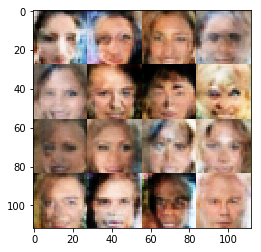

Epoch: 1/1... Discriminator Training Loss: 0.4724 Generator Training Loss: 1.5476
Epoch: 1/1... Discriminator Training Loss: 0.4876 Generator Training Loss: 1.3095
Epoch: 1/1... Discriminator Training Loss: 0.7535 Generator Training Loss: 1.7326
Epoch: 1/1... Discriminator Training Loss: 0.4269 Generator Training Loss: 1.7467
Epoch: 1/1... Discriminator Training Loss: 0.3094 Generator Training Loss: 1.9328
Epoch: 1/1... Discriminator Training Loss: 0.3974 Generator Training Loss: 1.6198
Epoch: 1/1... Discriminator Training Loss: 1.1923 Generator Training Loss: 0.5534
Epoch: 1/1... Discriminator Training Loss: 0.5253 Generator Training Loss: 1.8403
Epoch: 1/1... Discriminator Training Loss: 0.6934 Generator Training Loss: 1.0532
Epoch: 1/1... Discriminator Training Loss: 0.2956 Generator Training Loss: 2.1946


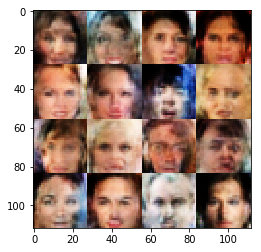

Epoch: 1/1... Discriminator Training Loss: 0.2788 Generator Training Loss: 2.0538
Epoch: 1/1... Discriminator Training Loss: 0.1915 Generator Training Loss: 2.9438
Epoch: 1/1... Discriminator Training Loss: 1.6404 Generator Training Loss: 5.8760
Epoch: 1/1... Discriminator Training Loss: 0.6127 Generator Training Loss: 3.9142
Epoch: 1/1... Discriminator Training Loss: 0.3378 Generator Training Loss: 2.9050
Epoch: 1/1... Discriminator Training Loss: 0.6583 Generator Training Loss: 1.0499
Epoch: 1/1... Discriminator Training Loss: 0.5483 Generator Training Loss: 1.2357
Epoch: 1/1... Discriminator Training Loss: 0.8080 Generator Training Loss: 0.8768
Epoch: 1/1... Discriminator Training Loss: 0.5587 Generator Training Loss: 1.2361
Epoch: 1/1... Discriminator Training Loss: 0.3870 Generator Training Loss: 1.9264


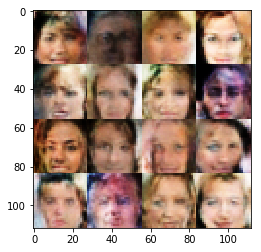

Epoch: 1/1... Discriminator Training Loss: 0.6164 Generator Training Loss: 1.8861
Epoch: 1/1... Discriminator Training Loss: 0.5625 Generator Training Loss: 1.8200
Epoch: 1/1... Discriminator Training Loss: 0.6352 Generator Training Loss: 1.1341
Epoch: 1/1... Discriminator Training Loss: 0.2545 Generator Training Loss: 2.1954
Epoch: 1/1... Discriminator Training Loss: 0.4689 Generator Training Loss: 1.3729
Epoch: 1/1... Discriminator Training Loss: 0.7634 Generator Training Loss: 1.0053
Epoch: 1/1... Discriminator Training Loss: 0.4964 Generator Training Loss: 2.4282
Epoch: 1/1... Discriminator Training Loss: 0.7859 Generator Training Loss: 0.9115
Epoch: 1/1... Discriminator Training Loss: 0.1111 Generator Training Loss: 3.6537
Epoch: 1/1... Discriminator Training Loss: 0.9012 Generator Training Loss: 0.7124


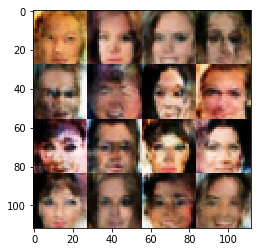

Epoch: 1/1... Discriminator Training Loss: 0.5357 Generator Training Loss: 1.4571
Epoch: 1/1... Discriminator Training Loss: 0.2575 Generator Training Loss: 2.2507
Epoch: 1/1... Discriminator Training Loss: 0.7119 Generator Training Loss: 1.0833
Epoch: 1/1... Discriminator Training Loss: 0.4952 Generator Training Loss: 2.7623
Epoch: 1/1... Discriminator Training Loss: 0.6986 Generator Training Loss: 1.1425
Epoch: 1/1... Discriminator Training Loss: 0.4815 Generator Training Loss: 1.5791
Epoch: 1/1... Discriminator Training Loss: 0.7110 Generator Training Loss: 1.9522
Epoch: 1/1... Discriminator Training Loss: 0.5839 Generator Training Loss: 2.5998
Epoch: 1/1... Discriminator Training Loss: 0.4754 Generator Training Loss: 1.3169
Epoch: 1/1... Discriminator Training Loss: 1.2700 Generator Training Loss: 0.5114


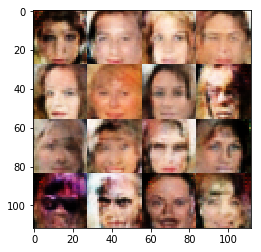

Epoch: 1/1... Discriminator Training Loss: 0.9204 Generator Training Loss: 2.0766
Epoch: 1/1... Discriminator Training Loss: 0.8000 Generator Training Loss: 0.8794
Epoch: 1/1... Discriminator Training Loss: 0.4525 Generator Training Loss: 2.5646
Epoch: 1/1... Discriminator Training Loss: 2.1412 Generator Training Loss: 0.1937
Epoch: 1/1... Discriminator Training Loss: 1.2940 Generator Training Loss: 0.5067
Epoch: 1/1... Discriminator Training Loss: 1.0288 Generator Training Loss: 0.6931
Epoch: 1/1... Discriminator Training Loss: 0.9457 Generator Training Loss: 2.1691
Epoch: 1/1... Discriminator Training Loss: 0.5027 Generator Training Loss: 1.6171
Epoch: 1/1... Discriminator Training Loss: 1.0383 Generator Training Loss: 0.6748
Epoch: 1/1... Discriminator Training Loss: 0.3411 Generator Training Loss: 2.1380


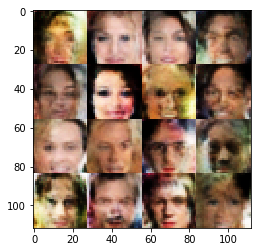

Epoch: 1/1... Discriminator Training Loss: 0.5310 Generator Training Loss: 1.2538
Epoch: 1/1... Discriminator Training Loss: 0.8857 Generator Training Loss: 0.7460
Epoch: 1/1... Discriminator Training Loss: 0.2141 Generator Training Loss: 3.2596
Epoch: 1/1... Discriminator Training Loss: 0.2615 Generator Training Loss: 3.6399
Epoch: 1/1... Discriminator Training Loss: 0.6133 Generator Training Loss: 1.8700
Epoch: 1/1... Discriminator Training Loss: 0.2042 Generator Training Loss: 2.2382
Epoch: 1/1... Discriminator Training Loss: 0.1735 Generator Training Loss: 2.8965
Epoch: 1/1... Discriminator Training Loss: 0.1382 Generator Training Loss: 3.5720
Epoch: 1/1... Discriminator Training Loss: 1.0148 Generator Training Loss: 0.7922
Epoch: 1/1... Discriminator Training Loss: 0.6757 Generator Training Loss: 1.1924


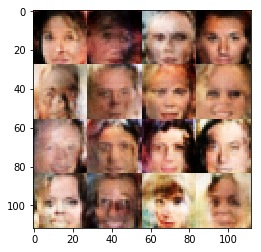

Epoch: 1/1... Discriminator Training Loss: 0.2924 Generator Training Loss: 2.5527
Epoch: 1/1... Discriminator Training Loss: 0.8524 Generator Training Loss: 0.8289
Epoch: 1/1... Discriminator Training Loss: 0.7772 Generator Training Loss: 0.9269
Epoch: 1/1... Discriminator Training Loss: 0.6478 Generator Training Loss: 3.3027
Epoch: 1/1... Discriminator Training Loss: 0.3924 Generator Training Loss: 1.9293
Epoch: 1/1... Discriminator Training Loss: 0.6863 Generator Training Loss: 1.0139


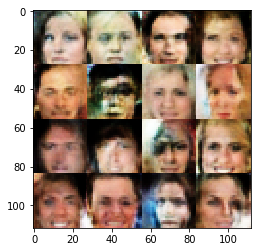

In [62]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.